In [26]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [38]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 25
SIZE = 200
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [39]:
X = torch.randn(SIZE, 2, dtype=DTYPE, device='cpu')
y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + .3 * torch.randn(SIZE, dtype=DTYPE, device='cpu')

In [ ]:
# Targets for Logistic Regression
probs = torch.sigmoid(y)
print(f"Probabilities:\n{probs}")

In [ ]:
y = (probs > .98).float()
print(f"Targets for logistic regression task:\n{y}")

In [ ]:
# Frequency of labels
print(f"# of Targets (0 and 1):" , "-> 0: {}".format(y[y == 0].numel()), "-> 1: {}".format(y[y == 1].numel()), sep="\n")

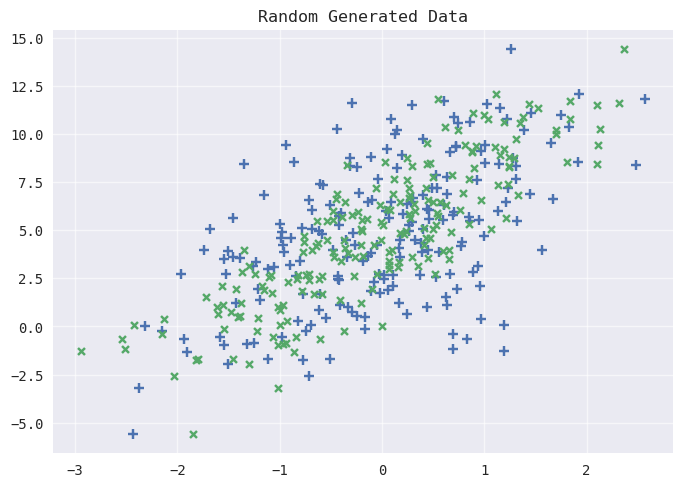

In [40]:
plt.scatter(X[:, 0].numpy(), y.numpy(), marker='+', s=50);
plt.scatter(X[:, 1].numpy(), y.numpy(), marker='x', s=25);
# plt.plot(
#     torch.sigmoid(torch.linspace(y.min(), y.max(), SIZE))
# )
plt.grid(True, alpha = .6);
plt.title("Random Generated Data");
plt.show()

In [41]:
X, X.shape

(tensor([[ 8.3392e-01, -2.5391e+00],
         [ 2.9771e-01,  2.1032e+00],
         [ 2.6474e-01, -1.9330e-01],
         [ 8.5074e-01, -3.9077e-01],
         [ 2.4797e-01,  3.1512e-01],
         [ 7.7550e-01, -6.4528e-01],
         [-7.0945e-01,  9.6727e-01],
         [-9.7864e-01,  6.7856e-01],
         [ 5.2397e-01, -1.1021e+00],
         [-6.0600e-01,  1.2310e+00],
         [-7.1369e-01, -2.0338e+00],
         [ 1.1413e+00,  4.3554e-01],
         [-9.3805e-01,  2.1070e+00],
         [ 1.1370e+00, -4.8268e-01],
         [ 2.8193e-01,  1.7280e-01],
         [ 1.0283e+00,  1.4387e+00],
         [-6.8016e-01,  7.6152e-01],
         [-6.1175e-01,  2.3799e-01],
         [-2.9614e-01,  2.3121e+00],
         [-3.4537e-01, -2.5955e-01],
         [-2.6281e-01, -7.8310e-02],
         [ 6.0099e-01, -1.9075e-01],
         [ 1.5651e+00, -1.3455e+00],
         [ 1.3239e+00, -6.3024e-01],
         [ 1.0615e-01, -7.4029e-01],
         [ 9.3505e-01, -1.2960e+00],
         [ 6.0485e-01, -1.9890e-02],
 

In [42]:
y, y.shape

(tensor([-6.6223e-01,  1.1502e+01,  4.9686e+00,  5.7107e+00,  6.3790e+00,
          4.1908e+00,  6.5956e+00,  4.8938e+00,  2.5889e+00,  7.4179e+00,
         -2.5766e+00,  8.4549e+00,  9.4123e+00,  6.0094e+00,  6.4510e+00,
          1.1537e+01,  6.0469e+00,  4.9387e+00,  1.1627e+01,  3.5987e+00,
          4.2081e+00,  5.5076e+00,  3.9957e+00,  5.5069e+00,  2.6982e+00,
          3.1507e+00,  6.3168e+00,  5.0494e+00, -8.6840e-01,  6.8364e+00,
          1.0973e+01, -1.3128e+00,  2.7004e-03,  4.8935e-01,  6.8448e+00,
         -1.6990e+00,  2.7364e+00,  4.2331e+00,  8.3197e+00,  7.6766e+00,
          5.3078e+00,  9.3298e+00,  2.6673e+00,  4.7220e+00, -1.7512e+00,
          8.3875e+00,  3.0075e+00,  1.0915e+00,  4.5032e+00,  1.0234e+01,
         -5.5311e-01,  3.1648e+00,  2.7032e+00,  8.9282e+00,  2.6386e+00,
          5.4871e+00,  1.7020e+00,  3.9876e+00,  3.5507e+00,  8.7713e+00,
          6.0749e+00,  3.2045e+00,  3.9978e+00,  7.8906e+00,  2.4896e+00,
         -1.2951e+00,  4.4787e+00,  2.

In [43]:
Data = TensorDataset(X, y)
Data.tensors

(tensor([[ 8.3392e-01, -2.5391e+00],
         [ 2.9771e-01,  2.1032e+00],
         [ 2.6474e-01, -1.9330e-01],
         [ 8.5074e-01, -3.9077e-01],
         [ 2.4797e-01,  3.1512e-01],
         [ 7.7550e-01, -6.4528e-01],
         [-7.0945e-01,  9.6727e-01],
         [-9.7864e-01,  6.7856e-01],
         [ 5.2397e-01, -1.1021e+00],
         [-6.0600e-01,  1.2310e+00],
         [-7.1369e-01, -2.0338e+00],
         [ 1.1413e+00,  4.3554e-01],
         [-9.3805e-01,  2.1070e+00],
         [ 1.1370e+00, -4.8268e-01],
         [ 2.8193e-01,  1.7280e-01],
         [ 1.0283e+00,  1.4387e+00],
         [-6.8016e-01,  7.6152e-01],
         [-6.1175e-01,  2.3799e-01],
         [-2.9614e-01,  2.3121e+00],
         [-3.4537e-01, -2.5955e-01],
         [-2.6281e-01, -7.8310e-02],
         [ 6.0099e-01, -1.9075e-01],
         [ 1.5651e+00, -1.3455e+00],
         [ 1.3239e+00, -6.3024e-01],
         [ 1.0615e-01, -7.4029e-01],
         [ 9.3505e-01, -1.2960e+00],
         [ 6.0485e-01, -1.9890e-02],
 

In [44]:
Model = LinearRegression(in_dims=2).to(DEVICE)

In [45]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.L1Loss(reduction='mean'),
    device=DEVICE
)

In [47]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-0.3466,  0.8178], device='cuda:0')
	Epoch 1 | Bias: tensor([-1.3060], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.3737,  0.7964], device='cuda:0')
	Epoch 1 | Bias: tensor([-1.2060], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.3498,  0.8502], device='cuda:0')
	Epoch 1 | Bias: tensor([-1.1185], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.3692,  0.8758], device='cuda:0')
	Epoch 1 | Bias: tensor([-1.0310], device='cuda:0')
	Epoch 1 | Weights: tensor([-0.3566,  0.8515], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.9310], device='cuda:0')
Epoch 1/25 | Loss: 6.0834
	| Validation Loss: 5.3427

	Epoch 2 | Weights: tensor([-0.3544,  0.8410], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.8373], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3506,  0.8323], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.7435], device='cuda:0')
	Epoch 2 | Weights: tensor([-0.3351,  0.8577], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.6498], device='cuda:0')
	Epoch 2 | Weights

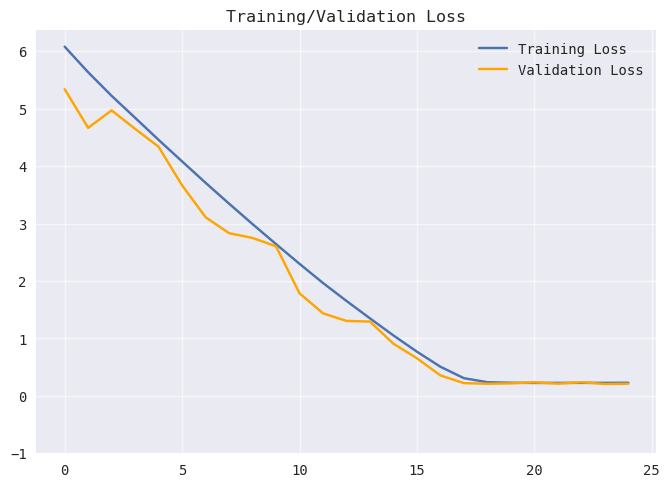

In [48]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=-1)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [49]:
# y = 2 * X[:, 0] + 3 * X[:, 1] + 5 + torch.randn(SIZE, dtype=DTYPE, device='cpu')
print(
    f"Trained Weights: {Model.w.data}",
    f"Trained Bias: {Model.b.data}",
    sep="\n"
)

Trained Weights: tensor([1.9924, 3.0535], device='cuda:0')
Trained Bias: tensor([5.0002], device='cuda:0')


In [50]:
# Analytical Solution
# First, bias must be added to the design matrix
X = torch.tensor(np.concatenate([X, np.ones((SIZE, 1))], axis=1), dtype=DTYPE, device='cpu')

w = torch.linalg.inv(X.T @ X) @ X.T @ y
print(f"Analytical Solution for Weights: {w}")

Analytical Solution for Weights: tensor([1.9880, 3.0087, 5.0063])


In [51]:
T = np.linspace(X.min(), X.max(), SIZE, dtype=np.float32).reshape(SIZE, 1)
T = torch.tensor(np.concatenate([T, T], axis=1), device=DEVICE)

# Inference
Model.eval()
with torch.no_grad():
    yT = Model(T)

print(f"\nGenerated T:\n{T}")
print(f"\nPredictions:\n{yT}")


Generated T:
tensor([[-2.9371, -2.9371],
        [-2.9094, -2.9094],
        [-2.8817, -2.8817],
        [-2.8540, -2.8540],
        [-2.8264, -2.8264],
        [-2.7987, -2.7987],
        [-2.7710, -2.7710],
        [-2.7433, -2.7433],
        [-2.7157, -2.7157],
        [-2.6880, -2.6880],
        [-2.6603, -2.6603],
        [-2.6326, -2.6326],
        [-2.6050, -2.6050],
        [-2.5773, -2.5773],
        [-2.5496, -2.5496],
        [-2.5219, -2.5219],
        [-2.4942, -2.4942],
        [-2.4666, -2.4666],
        [-2.4389, -2.4389],
        [-2.4112, -2.4112],
        [-2.3835, -2.3835],
        [-2.3559, -2.3559],
        [-2.3282, -2.3282],
        [-2.3005, -2.3005],
        [-2.2728, -2.2728],
        [-2.2452, -2.2452],
        [-2.2175, -2.2175],
        [-2.1898, -2.1898],
        [-2.1621, -2.1621],
        [-2.1345, -2.1345],
        [-2.1068, -2.1068],
        [-2.0791, -2.0791],
        [-2.0514, -2.0514],
        [-2.0238, -2.0238],
        [-1.9961, -1.9961],
      

In [52]:
T.shape, yT.shape

(torch.Size([200, 2]), torch.Size([200]))

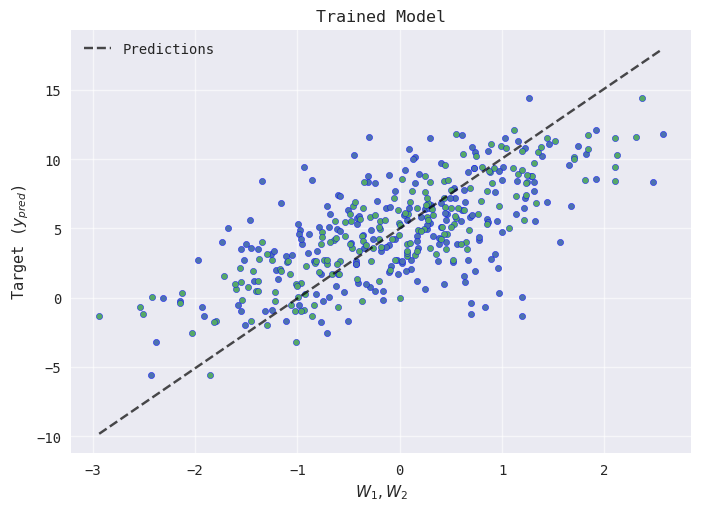

In [ ]:
plt.scatter(X[:, 0].numpy(), y.numpy(), marker='+', s=50);
plt.scatter(X[:, 1].numpy(), y.numpy(), marker='x', s=25);
# Predicted Linear Model
plt.plot(T[:, 0].cpu().numpy(), yT.cpu().numpy(), color="black", alpha=.7, linestyle='--', label="Predictions");
plt.grid(True, alpha = .6);
plt.title("Trained Model");
plt.xlabel("$W_1, W_2$");
plt.ylabel("Target ($y_{pred}$)");
plt.legend(loc='best');
plt.show()